In [2]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from coosys import cartesian_to_kepler as ctk, cartesian_to_quaternion as ctq
from coosys import kepler_to_cartesian as ktc, quaternion_to_cartesian as qtc

from sklearn.preprocessing import PolynomialFeatures as PF
from tqdm.auto import tqdm
tqdm.pandas()


# Train simple baseline (Linear Regression models)

metric: [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [3]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('Track 1/test.csv')
train.shape

(649912, 15)

In [4]:
test.head()


,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


Adding some time features

In [11]:

train['day'] = pd.to_datetime(train.epoch).dt.day
test['day'] = pd.to_datetime(test.epoch).dt.day
train['hour'] = pd.to_datetime(train.epoch).dt.hour
test['hour'] = pd.to_datetime(test.epoch).dt.hour
train = train.sort_values(by='day')
train.head()

sats_to_predict = set(test["sat_id"].unique())

categ = ['day', 'hour']
other = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categ),
    ('scaling', 'passthrough', other)
])

column_transformer.fit(train)
train_t = column_transformer.transform(train)
test_t = column_transformer.transform(test)

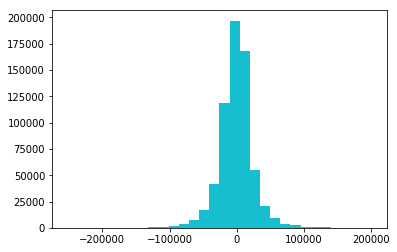

In [14]:
for i in range(20):
    plt.hist(train.x, bins=30)
plt.show()

In [15]:
gamma_km = 398603

def transform_row(row, func):
    return func(row.values)

def transform_dataset(data, func=lambda data: ctk(data, gamma_km), 
                      columns_from=("x", "y", "z", "Vx", "Vy", "Vz"), 
                      columns_to=("a", "e", "inclination", "longitude", "argument", "anomaly")):
    new_data = data.loc[:, list(columns_from)].apply(transform_row, axis=1, result_type="expand", args=(func, ))
    new_data.columns = columns_to
    return data.drop(list(columns_from), axis=1).join(new_data)

In [84]:
train_quaternion = transform_dataset(train, func=lambda data: ctq(data, gamma_km),
                                     columns_from=("x", "y", "z", "Vx", "Vy", "Vz"),
                                     columns_to=(("a", "e", "anomaly", "q1", "q2", "q3", "q4")))
train_quaternion = transform_dataset(train_quaternion, func=lambda data: ctq(data, gamma_km), 
                                     columns_from=("x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"),
                                     columns_to=("a_sim", "e_sim", "anomaly_sim", "q1_sim", "q2_sim", "q3_sim", "q4_sim"))

test_quaternion = transform_dataset(test, func=lambda data: ctq(data, gamma_km), 
                                    columns_from=("x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"),
                                    columns_to=("a_sim", "e_sim", "anomaly_sim", "q1_sim", "q2_sim", "q3_sim", "q4_sim"))

In [64]:
train_quaternion.head()

,sat_id,day,a,e,anomaly,q1,q2,q3,q4,a_sim,e_sim,anomaly_sim,q1_sim,q2_sim,q3_sim,q4_sim
0,0,1,35750.114408,0.270492,8.560065e-08,-0.593575,0.389910,0.386518,-0.588424,35748.665023,0.270000,0.000784,-0.593442,0.390131,0.386726,-0.588275
87682,83,1,49685.701978,0.171211,3.716588e+00,-0.449788,0.838916,-0.270081,0.144799,49685.522688,0.170323,3.716723,-0.449794,0.839090,-0.269665,0.144548
87683,83,1,49684.872139,0.171229,3.922217e+00,-0.449791,0.838916,-0.270077,0.144798,49685.739285,0.170321,3.922636,-0.449794,0.839092,-0.269661,0.144545
87684,83,1,49684.811687,0.171240,4.140187e+00,-0.449793,0.838916,-0.270074,0.144797,49686.055100,0.170321,4.140800,-0.449794,0.839093,-0.269657,0.144543
87685,83,1,49685.602703,0.171246,4.374387e+00,-0.449794,0.838916,-0.270073,0.144797,49686.443023,0.170324,4.375054,-0.449794,0.839094,-0.269655,0.144542


In [65]:
test_quaternion.head()

,sat_id,day,a_sim,e_sim,anomaly_sim,q1_sim,q2_sim,q3_sim,q4_sim
0,1,1,21111.035679,0.468304,4.276208,-0.964330,0.248479,0.022769,-0.088358
1,1,1,21110.224464,0.468324,4.558021,-0.964336,0.248466,0.022759,-0.088328
2,1,1,21108.805096,0.468320,4.948948,-0.964345,0.248455,0.022744,-0.088273
3,1,1,21108.010434,0.468310,5.518140,-0.964351,0.248462,0.022723,-0.088191
4,1,1,21110.673154,0.468376,0.002943,-0.964345,0.248497,0.022718,-0.088158


In [16]:
# target variables columns 
target_cols = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
#target_cols = ['a', 'e', 'anomaly', 'q1', 'q2', 'q3', 'q4',]
# features columns 
feature_cols = [c for c in train.columns if c not in target_cols and c != 'epoch' and c != 'sat_id']
# number of rows for training, validation and prediction
n_train = train.shape[0]
n_val = int(0.2 * n_train)
n_train = n_train - n_val
n_test = test.shape[0]

print(f"n_train: {n_train}\nn_val: {n_val}\nn_test: {n_test}")
#assert n_train + n_val == train.shape[0]

# train, validation, test arrays
X_train = train[feature_cols].values
y_train = dict(zip(target_cols, [train[l].values for l in target_cols]))
X_val = train[feature_cols].values[n_train:n_train+n_val]
y_val = dict(zip(target_cols, [train[l].values[n_train:n_train+n_val] for l in target_cols]))
X_test = test[feature_cols].values

#assert X_train.shape[0] == y_train[target_cols[0]].shape[0] == n_train
assert X_val.shape[0] == y_val[target_cols[0]].shape[0] == n_val
assert X_test.shape[0] == n_test

n_train: 519930
n_val: 129982
n_test: 284071


Predict 6 coordinates one by one (worked slightly better)

In [56]:
def predict_one(train_quaternion, test_quaternion, degree=1):
    #train_sat = train_quaternion[train_quaternion.sat_id == sat_id]
    #test_sat = test_quaternion[test_quaternion.sat_id == sat_id]
    result = pd.DataFrame(columns=["id", 'x', 'y', 'z', 'Vx', 'Vy', 'Vz'])
    
    result["id"] = test["id"]
    
    train_features = ['hour', 'day', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
    test_features = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
    for coordinate in ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']:
        train_diff = train[coordinate] - train[coordinate + "_sim"]
        train_diff = np.array(train_diff).reshape(-1, 1)

        model = Ridge()
        train_t = column_transformer.transform(train[train_features])
        model.fit(train_t, train_diff)

        test_t = column_transformer.transform(test[train_features])
        #print(test[coordinate + "_sim"].shape, model.predict(test_t).shape)
        result[coordinate] = test[coordinate + "_sim"] + model.predict(test_t).reshape(-1, )
        
    #train_diff = phase_regression(train_sat["anomaly"].to_numpy()) - phase_regression(train_sat["anomaly_sim"].to_numpy())
    #model = LinearRegression().fit(train_features, train_diff)
    #result["anomaly"] = phase_degression(test_sat["anomaly_sim"].to_numpy() + model.predict(test_features))
    
    #if np.any(result["e"].to_numpy() >= 1.) or np.any(result["e"].to_numpy() < 0.):
        #result["e"] = test_sat["e_sim"]

    return result

In [57]:
results = []

#for sat_id in tqdm(sats_to_predict):
#    results.append(predict_one(train, test, sat_id))
    
result = predict_one(train, test)

In [60]:
result.index = result.id
result.drop('id', axis=1, inplace=True)


In [61]:
result.to_csv('predictions.csv')

In [58]:
result_quaternion

,id,x,y,z,Vx,Vy,Vz
0,3927,-12595.531033,-13860.943848,5926.795414,4.286915,-0.731256,0.841993
1,3928,-6837.721178,-14050.884151,6670.825913,5.034048,0.323971,0.354062
2,3929,-323.744368,-12593.311081,6634.492157,5.482309,1.977449,-0.492386
3,3930,6156.493989,-8662.160840,5299.187251,4.826517,4.303513,-1.823344
4,3931,10488.809397,-1946.679157,2265.186777,1.944092,6.161347,-3.136209
...,...,...,...,...,...,...,...
284066,1231060,28604.333705,-81641.729674,4228.493051,-1.627582,-0.077548,0.212984
284067,1231061,16051.655589,-80655.176090,4969.271686,-1.741344,0.263617,0.184210
284068,1231062,2967.629684,-76903.353861,5539.422507,-1.807036,0.662737,0.144367
284069,1231063,-10212.556021,-69942.255685,5877.921092,-1.798321,1.134456,0.090226


In [59]:
test

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,1,0
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,1,0
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,1,0
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,1,1
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,1,1
...,...,...,...,...,...,...,...,...,...,...,...
284066,1231060,597,2014-02-28T05:19:01.386,28595.031634,-85458.623976,5021.767767,-1.721131,-0.011611,0.122357,28,5
284067,1231061,597,2014-02-28T07:21:46.454,15547.173728,-84233.509948,5840.616702,-1.815323,0.353445,0.098927,28,7
284068,1231062,597,2014-02-28T09:24:31.522,1981.107111,-80123.860051,6458.394351,-1.858963,0.773846,0.067379,28,9
284069,1231063,597,2014-02-28T11:27:16.590,-11644.801379,-72674.504171,6805.361999,-1.826030,1.262930,0.024782,28,11


Predict 6 coordinates at one time

In [95]:
# dictionary: {variable: LR predictions}
y_test = {}

_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = LinearRegression().fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = LinearRegression().fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))

x
MAPE train:  153.7868452280808
MAPE val:  196.61063647438687 

y
MAPE train:  317.18745607326355
MAPE val:  267.42317790057643 

z
MAPE train:  321.97972152877765
MAPE val:  350.56668013519936 

Vx
MAPE train:  191.25675329409856
MAPE val:  315.7228145682371 

Vy
MAPE train:  134.42911944517954
MAPE val:  192.86740383289666 

Vz
MAPE train:  1035.6067536033372
MAPE val:  463.76238044126967 

------
mean MAPE train:  359.0411081954562
mean MAPE val:  297.82551555876097


In [104]:
res = pd.DataFrame()

res['x'] = y_test['x']
res['y'] = y_test['y']
res['z'] = y_test['z']
res['Vx'] = y_test['Vx']
res['Vy'] = y_test['Vy']
res['Vz'] = y_test['Vz']
res.index = test.id
predictions = pd.DataFrame(res, index=test.id[-n_test:])

res.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13670.775275,-14378.827605,5138.391144,3.558354,-0.545464,0.874702
3928,-8071.832174,-14848.017677,6147.384454,4.215326,0.330379,0.498611
3929,-1669.322349,-13742.150723,6601.844753,4.640011,1.694490,-0.187929
3930,4888.221187,-10138.980516,6083.159497,4.160835,3.598294,-1.319466
3931,9668.065944,-3375.682862,3931.941334,1.808036,5.090177,-2.521150


In [107]:
result_cartesian = transform_dataset(res, func=lambda data: qtc(data, gamma_km), 
                                     columns_from=("a", "e", "anomaly", "q1", "q2", "q3", "q4"),
                                     columns_to=("x", "y", "z", "Vx", "Vy", "Vz"))

In [109]:
# predictions
predictions = pd.DataFrame(result_cartesian, index=test.index[-n_test:])
predictions.to_csv('predictions.csv')